In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load Simulated Matches

In [2]:
df = pd.read_csv('../results/simulated_matches.csv')
print(f"Total simulated matches: {len(df)}")
df.head(15)

Total simulated matches: 130000


,simulation,match,match_type,opponent_team,player_elo,opponent_elo,win_elo,delta_elo,win_ml,delta_ml
0,1,1,league,Mandement,1468,1721,0,-0.772888,0,-0.772888
1,1,2,league,Mandement,1468,1823,0,-0.247663,0,-0.247663
2,1,3,league,Mandement,1468,1368,1,3.603796,1,3.603796
3,1,4,league,Bulle,1468,1533,1,10.182254,1,10.182254
4,1,5,league,Bulle,1468,1676,0,-1.253679,0,-1.253679
5,1,6,league,Bulle,1468,1592,0,-2.902087,0,-2.902087
6,1,7,national,National,1468,1860,0,-0.162688,0,-0.162688
7,1,8,national,National,1468,1435,1,6.092169,1,6.092169
8,1,9,national,National,1468,1545,1,10.622496,0,-4.377504
9,1,10,national,National,1468,1297,1,1.837912,1,1.837912


## Summary Statistics

In [5]:
# Group by simulation to get final Elo for each
sim_results = df.groupby('simulation').agg({
    'delta_elo': 'sum',
    'delta_ml': 'sum',
    'win_elo': 'sum',
    'win_ml': 'sum'
}).reset_index()

PLAYER_ELO = 1468
sim_results['final_elo_swiss'] = PLAYER_ELO + sim_results['delta_elo']
sim_results['final_elo_ml'] = PLAYER_ELO + sim_results['delta_ml']

print("=== Swiss Elo Formula ===")
print(f"Mean final Elo: {sim_results['final_elo_swiss'].mean():.1f}")
print(f"Std deviation: {sim_results['final_elo_swiss'].std():.1f}")
print(f"Min: {sim_results['final_elo_swiss'].min():.1f}, Max: {sim_results['final_elo_swiss'].max():.1f}")
print(f"90% interval: [{sim_results['final_elo_swiss'].quantile(0.05):.1f}, {sim_results['final_elo_swiss'].quantile(0.95):.1f}]")

print("\n=== ML Model ===")
print(f"Mean final Elo: {sim_results['final_elo_ml'].mean():.1f}")
print(f"Std deviation: {sim_results['final_elo_ml'].std():.1f}")
print(f"Min: {sim_results['final_elo_ml'].min():.1f}, Max: {sim_results['final_elo_ml'].max():.1f}")
print(f"90% interval: [{sim_results['final_elo_ml'].quantile(0.05):.1f}, {sim_results['final_elo_ml'].quantile(0.95):.1f}]")

=== Swiss Elo Formula ===
Mean final Elo: 1468.0
Std deviation: 18.3
Min: 1395.6, Max: 1545.0
90% interval: [1437.2, 1497.7]

=== ML Model ===
Mean final Elo: 1469.9
Std deviation: 18.9
Min: 1400.2, Max: 1538.8
90% interval: [1438.7, 1501.0]


## Final Elo Distribution

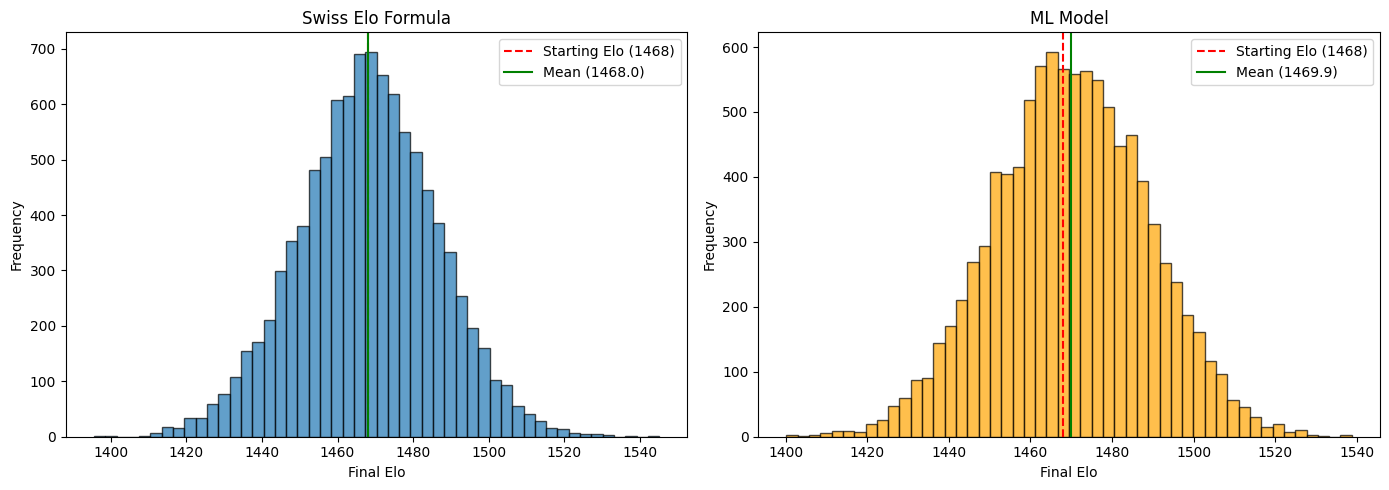

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Swiss Elo
axes[0].hist(sim_results['final_elo_swiss'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(PLAYER_ELO, color='red', linestyle='--', label=f'Starting Elo ({PLAYER_ELO})')
axes[0].axvline(sim_results['final_elo_swiss'].mean(), color='green', linestyle='-', label=f'Mean ({sim_results["final_elo_swiss"].mean():.1f})')
axes[0].set_xlabel('Final Elo')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Swiss Elo Formula')
axes[0].legend()

# ML Model
axes[1].hist(sim_results['final_elo_ml'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].axvline(PLAYER_ELO, color='red', linestyle='--', label=f'Starting Elo ({PLAYER_ELO})')
axes[1].axvline(sim_results['final_elo_ml'].mean(), color='green', linestyle='-', label=f'Mean ({sim_results["final_elo_ml"].mean():.1f})')
axes[1].set_xlabel('Final Elo')
axes[1].set_ylabel('Frequency')
axes[1].set_title('ML Model')
axes[1].legend()

plt.tight_layout()
plt.show()

## Win Rate by Match Type

In [6]:
win_rates = df.groupby(['match_type', 'opponent_team']).agg({
    'win_elo': 'mean',
    'win_ml': 'mean',
    'opponent_elo': 'mean'
}).round(3)

win_rates.columns = ['Win Rate (Swiss)', 'Win Rate (ML)', 'Avg Opponent Elo']
win_rates

Win Rate (Swiss)  Win Rate (ML)  Avg Opponent Elo
match_type opponent_team                                                   
league     Bulle                     0.274          0.302          1565.814
           Mandement                 0.410          0.420          1539.484
national   National                  0.679          0.681          1369.959

## Win Rate vs Elo Difference

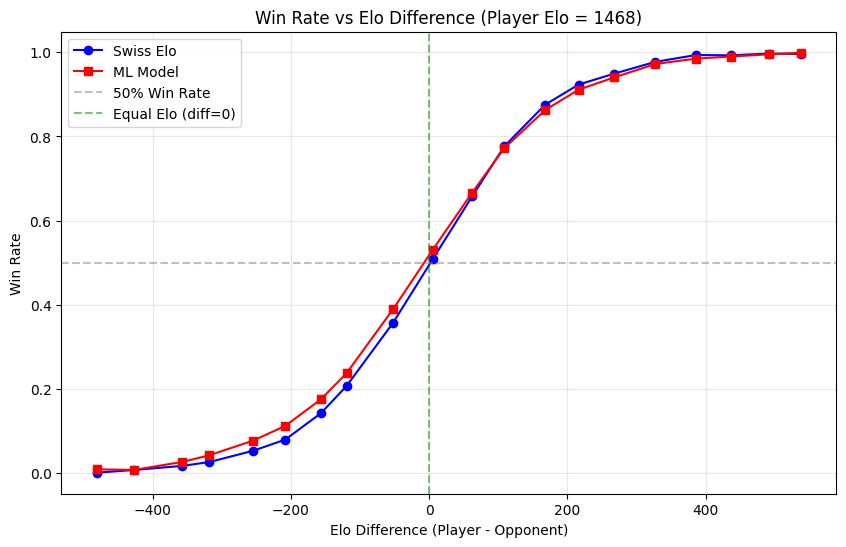

In [12]:
# Calculate Elo difference (Player Elo - Opponent Elo)
df['elo_diff'] = PLAYER_ELO - df['opponent_elo']

# Bin by Elo difference and calculate win rate
df['elo_diff_bin'] = pd.cut(df['elo_diff'], bins=20)
elo_win_rate = df.groupby('elo_diff_bin', observed=True).agg({
    'win_elo': 'mean',
    'win_ml': 'mean',
    'elo_diff': ['mean', 'count']
}).dropna()

plt.figure(figsize=(10, 6))
plt.plot(elo_win_rate['elo_diff']['mean'], elo_win_rate['win_elo']['mean'], 'b-o', label='Swiss Elo')
plt.plot(elo_win_rate['elo_diff']['mean'], elo_win_rate['win_ml']['mean'], 'r-s', label='ML Model')
plt.axhline(0.5, color='gray', linestyle='--', alpha=0.5, label='50% Win Rate')
plt.axvline(0, color='green', linestyle='--', alpha=0.5, label='Equal Elo (diff=0)')
plt.xlabel('Elo Difference (Player - Opponent)')
plt.ylabel('Win Rate')
plt.title(f'Win Rate vs Elo Difference (Player Elo = {PLAYER_ELO})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Total Wins per Simulation

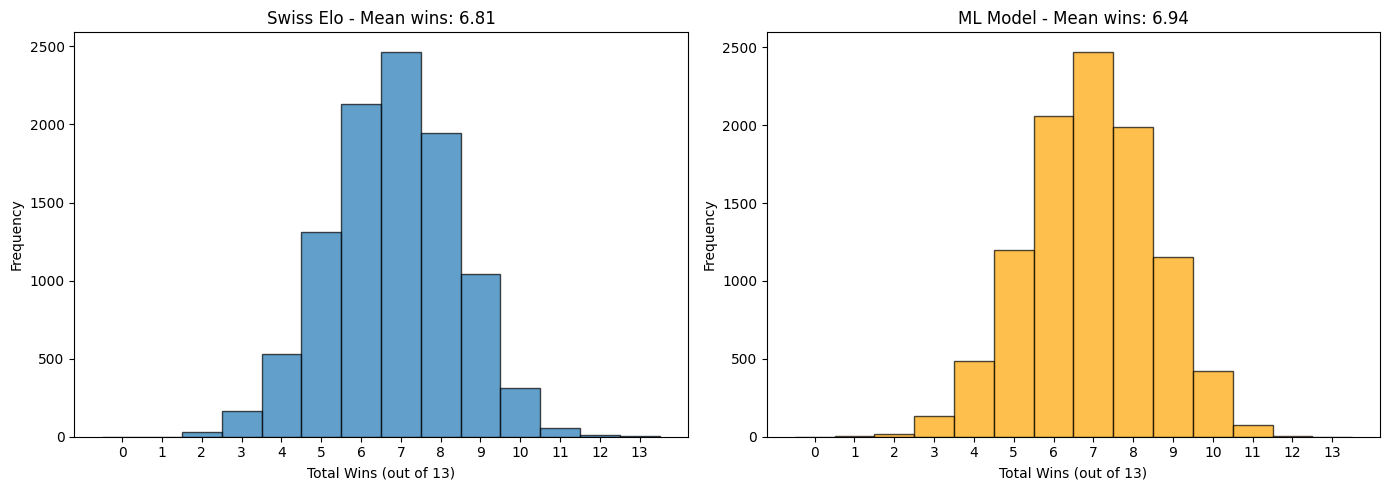

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Swiss Elo wins
axes[0].hist(sim_results['win_elo'], bins=range(0, 15), edgecolor='black', alpha=0.7, align='left')
axes[0].set_xlabel('Total Wins (out of 13)')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'Swiss Elo - Mean wins: {sim_results["win_elo"].mean():.2f}')
axes[0].set_xticks(range(0, 14))

# ML wins
axes[1].hist(sim_results['win_ml'], bins=range(0, 15), edgecolor='black', alpha=0.7, color='orange', align='left')
axes[1].set_xlabel('Total Wins (out of 13)')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'ML Model - Mean wins: {sim_results["win_ml"].mean():.2f}')
axes[1].set_xticks(range(0, 14))

plt.tight_layout()
plt.show()

## Win/Loss Scatter Plot (Player Elo vs Opponent Elo)

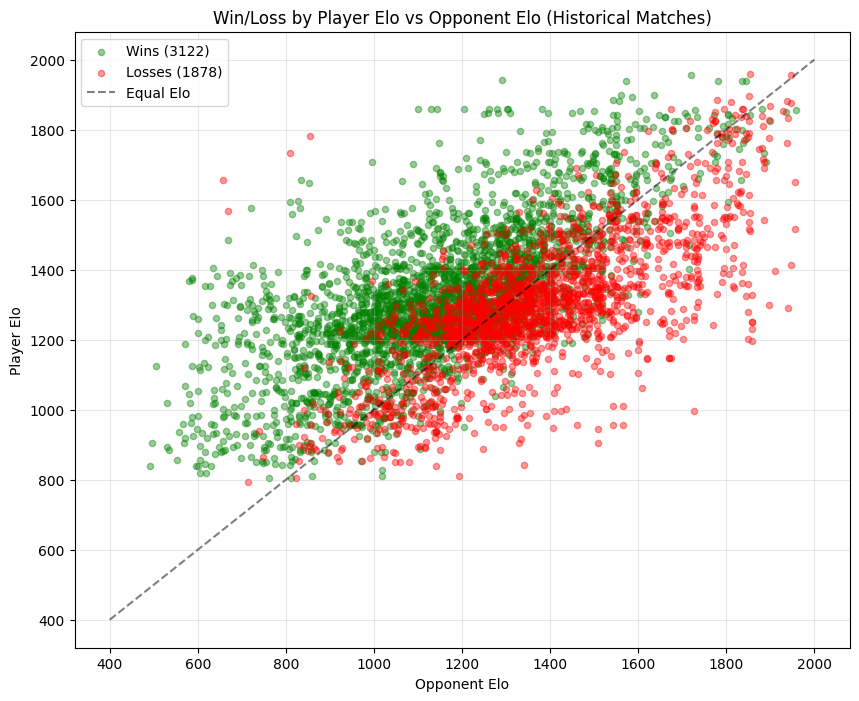

In [9]:
# Use historical matches for scatter plot
# Sample a subset for better visualization
sample_hist = historical_df.sample(n=5000, random_state=42)

wins = sample_hist[sample_hist['win'] == 1]
losses = sample_hist[sample_hist['win'] == 0]

plt.figure(figsize=(10, 8))
plt.scatter(wins['opponent_elo'], wins['player_elo'], c='green', alpha=0.4, label=f'Wins ({len(wins)})', s=20)
plt.scatter(losses['opponent_elo'], losses['player_elo'], c='red', alpha=0.4, label=f'Losses ({len(losses)})', s=20)

# Add diagonal line (equal Elo)
plt.plot([400, 2000], [400, 2000], 'k--', alpha=0.5, label='Equal Elo')

plt.xlabel('Opponent Elo')
plt.ylabel('Player Elo')
plt.title('Win/Loss by Player Elo vs Opponent Elo (Historical Matches)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()